# Day 26

Yesterday I saw a possible difference between the scoring distribution of seasons 1999-2010 and 2011-2022. I'm going to perform a two sample t-test to see if the difference is significant.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pingouin

np.random.seed(2022)

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Query Data

In [30]:
query = """
SELECT
    game_id,
    team,
    pbp_score AS score
FROM pbp_score_summary
WHERE pbp_score IS NOT NULL
"""

df = pd.read_sql(query, conn)
print(len(df))
df.head()

12568


,game_id,team,score
0,1999_01_MIN_ATL,ATL,14.0
1,1999_01_KC_CHI,CHI,20.0
2,1999_01_PIT_CLE,CLE,0.0
3,1999_01_OAK_GB,GB,28.0
4,1999_01_BUF_IND,IND,31.0


In [31]:
# Get season and week
df['season'] = df['game_id'].apply(lambda x: int(x[:4]))
df['week'] = df['game_id'].apply(lambda x: int(x[5:7]))

In [32]:
df.describe().round(2)

,score,season,week
count,12568.00,12568.00,12568.00
mean,22.06,2010.36,9.44
std,10.28,6.80,5.28
min,0.00,1999.00,1.00
25%,14.00,2004.00,5.00
50%,21.00,2010.00,9.00
75%,29.00,2016.00,14.00
max,62.00,2022.00,22.00


In [33]:
# Subset to regular season
reg_season = df.query("(season < 2021 & week < 17) | (season == 2021 & week < 18) | (season == 2022)")

## Check Distributions

### Populations

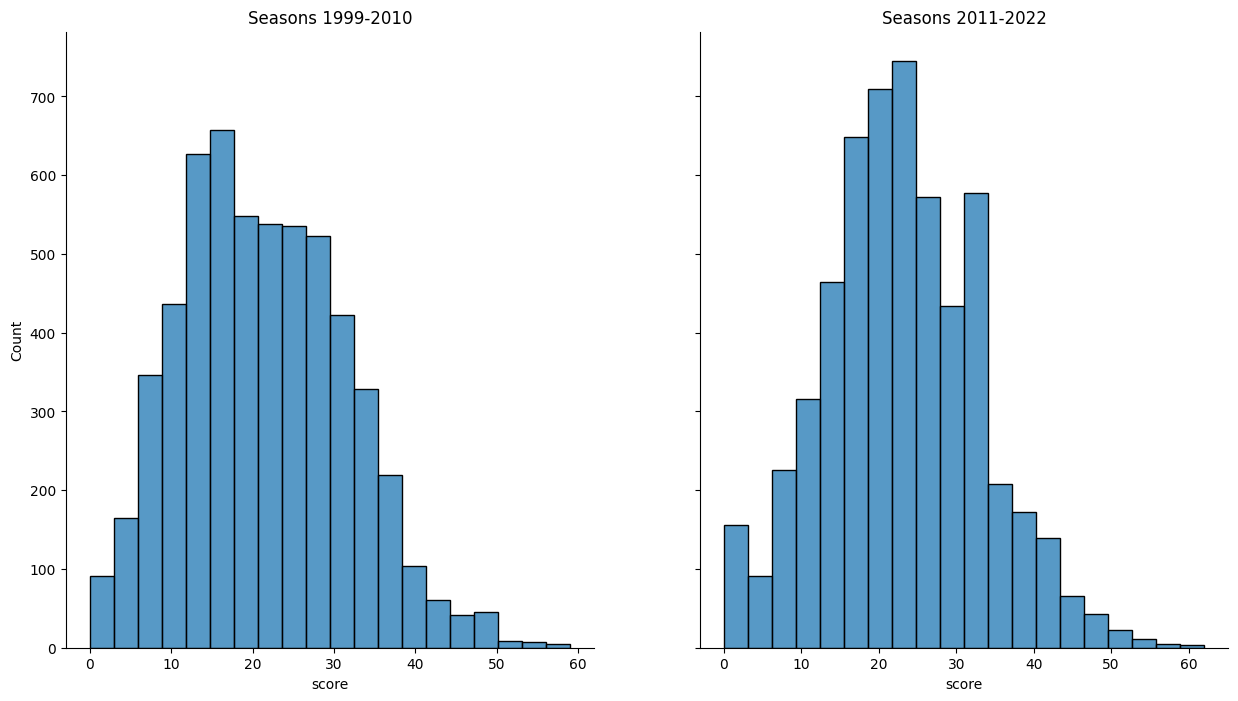

In [34]:
# Create figure, axes for subplots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))

sns.histplot(
    x='score',
    data=reg_season.query("season < 2011"),
    bins=20,
    ax=ax0
)

sns.histplot(
    x='score',
    data=reg_season.query("season >= 2011"),
    bins=20,
    ax=ax1
)

# Set titles
ax0.set_title("Seasons 1999-2010")
ax1.set_title("Seasons 2011-2022")

sns.despine()
plt.show()

Scores for each population are normally distributed.

### Samples

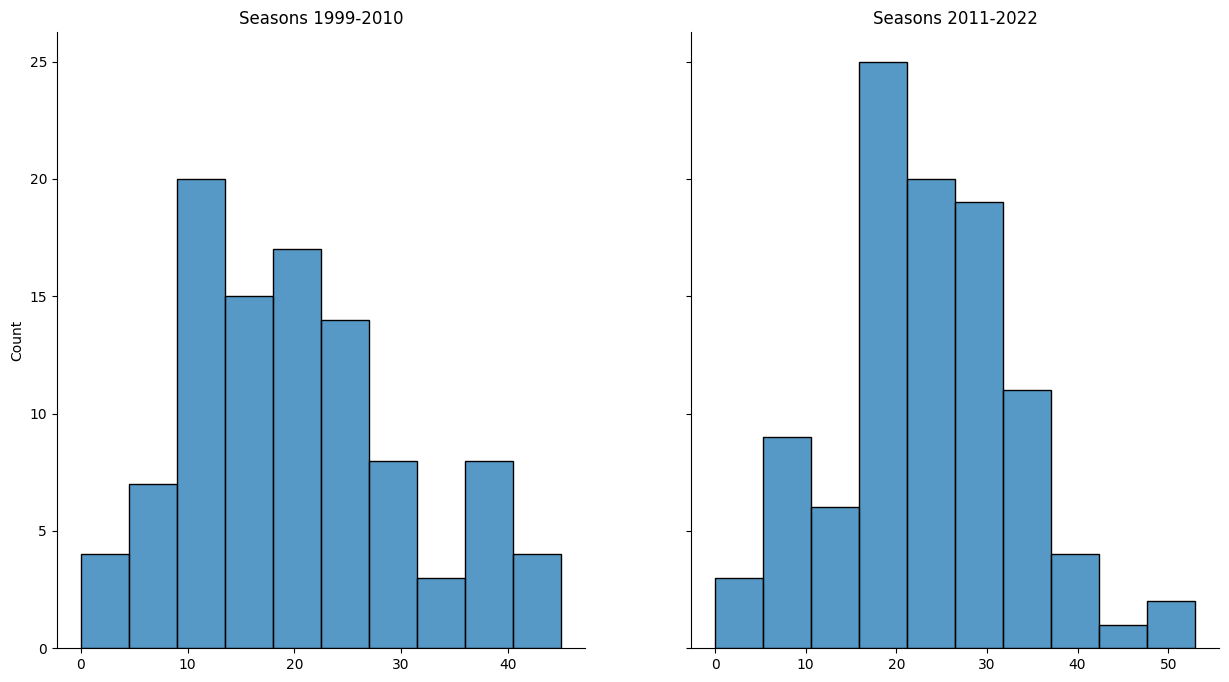

In [48]:
n = 100

sample_1999_2010 = np.random.choice(reg_season.query("season < 2011")['score'], size=n, replace=True)
sample_2011_2022 = np.random.choice(reg_season.query("season >= 2011")['score'], size=n, replace=True)

# Create figure, axes for subplots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))

sns.histplot(
    x=sample_1999_2010,
    bins=10,
    ax=ax0
)

sns.histplot(
    x=sample_2011_2022,
    bins=10,
    ax=ax1
)

# Set titles
ax0.set_title("Seasons 1999-2010")
ax1.set_title("Seasons 2011-2022")

sns.despine()
plt.show()

Scores for each sample seem normally distributed.

In [49]:
# Check standard deviation
print(f"Sample 1999-2010 Standard Deviation: {np.std(sample_1999_2010).round(2)}")
print(f"Sample 2011-2022 Standard Deviation: {np.std(sample_2011_2022).round(2)}")

Sample 1999-2010 Standard Deviation: 10.27
Sample 2011-2022 Standard Deviation: 10.02


Standard deviations are similar between the two samples

## Perform Hypothesis Test

### Set Up

H0 (null): The average score for teams during 1999-2010 is the same as the average score for teams in 2011-2022
H1 (alt): The average score for teams in 2011-2022 is higher than the average score for teams during 1999-2010

This will be a left-tailed test since I want to see if the mean of 1999-2010 is **less than** the mean of 2011-2022.

Assumptions:
- The observations in one sample should be independent of the observations in the other sample.
- The data should be approximately normally distributed.
- The two samples should have approximately the same variance.
- The data in both samples was obtained using a random sampling method.

I'll use a significance level of 0.05

In [52]:
pingouin.ttest(sample_1999_2010, sample_2011_2022, paired=False, alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.433878,198,less,0.007913,"[-inf, -1.13]",0.344202,4.8,0.782509


The p-value from the test is **less than the significance level** of 0.05 so I will reject the null hypothesis and conclude that the average score for a team during the 1999-2010 regular seasons is significantly less than the average score for a team during the 2011-2022 regular seasons.

In the future I'll try to understand why this might be the case. More touchdowns? Less penalties (or more penalties favoring offenses?). More 4th down conversions leading to more scoring opportunities for an offense?